# Inicializando acesso ao Google Drive

In [1]:
'''
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
'''

'\n# Install a Drive FUSE wrapper.\n# https://github.com/astrada/google-drive-ocamlfuse\n!apt-get install -y -qq software-properties-common python-software-properties module-init-tools\n!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null\n!apt-get update -qq 2>&1 > /dev/null\n!apt-get -y install -qq google-drive-ocamlfuse fuse\n'

In [2]:
'''
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

#print 'Files in Drive:'
!ls drive/"Colab Notebooks"/i2dl/tp1/dl/datasets/"cifar-10-batches-py"/
'''

'\n# Generate auth tokens for Colab\nfrom google.colab import auth\nauth.authenticate_user()\n\n# Generate creds for the Drive FUSE library.\nfrom oauth2client.client import GoogleCredentials\ncreds = GoogleCredentials.get_application_default()\nimport getpass\n!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL\nvcode = getpass.getpass()\n!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}\n\n# Create a directory and mount Google Drive using that directory.\n!mkdir -p drive\n!google-drive-ocamlfuse drive\n\n#print \'Files in Drive:\'\n!ls drive/"Colab Notebooks"/i2dl/tp1/dl/datasets/"cifar-10-batches-py"/\n'

# Atividade 02: Máquina de Vetor de Suporte (SVM) Multiclasse

*Complete e entregue toda essa atividade (incluindo suas saídas e qualquer código adicional que você desenvolva) juntamente com a submissão de seu trabalho prático. Maiores detalhes podem ser vistos na página da disciplina.*

Nessa atividade, você irá:

- implementar uma **função de perda** (**loss function**) de forma completamente paralela para SVM
- implementar a expressão para seu **gradiente analítico** de forma completamente paralela
- **verificar sua implementação** utilizando gradiente numérico
- usar um conjunto de validação para **ajustar a taxa de aprendizado e regularização**
- **otimizar** a função de perda com **SGD**
- **visualizar** os pesos finais que foram obtidos


In [1]:
# Executa algum código de inicialização para este notebook.

import random
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

from __future__ import print_function

# Um pouco de 'mágica': Isto permite que as figuras geradas pela biblioteca matplotlib apareçam dentro do notebook
# ao invés de aparecer em uma nova janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Um pouco mais de 'mágica', assim o notebook irá recarregar módulos python externos;
# veja mais em http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
'''
PATH_DIRECTORY = 'drive/Colab Notebooks/i2dl/tp1'
os.chdir(PATH_DIRECTORY)
'''
from dl.data_utils import load_CIFAR10

## CIFAR-10 Dataset: Carga e Preprocessamento dos Dados

In [3]:
# Carrega os dados brutos da base CIFAR-10.
cifar10_dir = 'dl/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Apenas para verificação, vamos exibir o tamanho dos dados de treinamento e teste.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


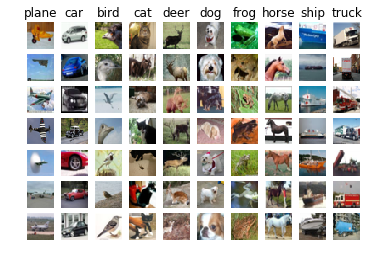

In [4]:
# Visualizar alguns exemplos do dataset.
# São exibidos apenas 7 exemplos de imagens de treinamento de cada classe.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Particiona os dados em conjuntos de treinamento, validação e teste.
# Além disso, cria-se um pequeno conjunto de dados de treinamento para
# ser usado durante o desenvolvimento. 
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# O conjunto de validação irá conter num_validation pontos do conjunto 
# original de treinamento.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# O conjunto de treinamento será formado pelos primeiros num_train pontos
# do conjunto original de treinamento.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Cria-se um conjunto para desenvolvimento, que será uma pequeno subconjunto
# do conjunto de treinamento.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# O conjunto de teste irá conter os primeiros num_test pontos do
# conjunto de testes (que corresponde a todo ele).
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessamento: reformata os dados das imagens, assim as matrizes são transformadas em vetores
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Apenas para verificação, vamos exibir o tamanho dos dados de treinamento, validação, teste e desenvolvimento.
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


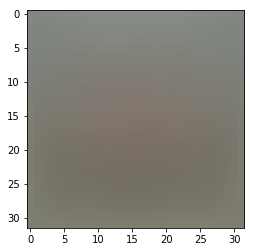

In [6]:
# Preprocessamento: subtrair a imagem média
# Primeiro: calcular a imagem média com base nos dados de treinamento
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # exibe alguns elementos
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualiza a imagem média
plt.show()

In [7]:
# Segundo: subtrai propriamente a imagem média dos dados de treinamento, validação, teste e desenvolvimento
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# Terceiro: acrescenta-se uma dimensão de 'uns' (conhecido como 'bias trick') assim nosso modelo SVM
# somente precisa se preocupar em otimizar uma única matriz de pesos W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Classificador SVM

Seu código para está seção será todo escrito dentro do arquivo `dl/classifiers/linear_svm.py`.

Como você pode observar (abrindo o arquivo em questão), a função `compute_loss_naive` já possui código para avaliar a função de perda do SVM multiclasse utilizando laços.

In [9]:
# Avalia a implementação ingênua de cálculo da função de perda já fornecida:
from dl.classifiers.linear_svm import svm_loss_naive
import time

# Produz uma matrix com números aleatórios e pequenos que serão usados como pesos do SVM 
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))
print(grad)

loss: 8.982316
[[-2.22163116e+01 -6.70256579e+00  3.06012530e-01 ... -2.83040285e-01
  -8.05222918e+00 -3.64015542e+01]
 [-3.64797716e+01 -2.48733347e+00  1.22495898e+00 ... -1.82767143e-01
  -2.09936439e+01 -4.22376712e+01]
 [-5.51798180e+01 -3.52161584e+00  6.03922522e+00 ...  9.77904572e-01
  -4.17193473e+01 -4.95485305e+01]
 ...
 [-2.30451590e+01  1.69769208e+00  2.19036261e+00 ... -5.75179771e+00
   1.07515763e+01 -1.22155153e+01]
 [-2.74047477e+01 -3.47732514e+00  5.04726943e+00 ...  3.15078200e+00
  -8.95203857e+00 -1.67671923e+01]
 [ 1.21999999e-01 -2.92000000e-01  1.62000000e-01 ... -4.19999999e-02
  -8.99999996e-02  1.79999986e-02]]


O **grad** retornado pela função acima ainda está todo zerado. Você deve derivar e implementar o gradiente para a função de custo (ou perda) do SVM e esse implementação deve ser colocada dentro da função `svm_loss_naive`. Provavelmente, você irá achar mais fácil combinar (e intercalar) seu código com o já existente na função (aproveitando os *loops* e  testes já existentes).

De forma a verificar se você implementou o gradiente analítico corretamente, pode-se estimar numericamento o gradiente da função de perda e comparar essa estimativa numérica com o valor calculado pela sua implementação. 

A seguir, você vai encontrar o código para realizar essa verificação.

In [10]:
print(W.shape, X_dev.shape)

(3073, 10) (500, 3073)


In [11]:
# uma vez que você tenha implementado o gradiente, recalcule seu valor com
# o código abaixo e verifique utilizando a função fornecida

# Calcula a perda e seu gadiente em W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Calcula numericamente o gradiente em diversas direções escolhidas randomicamente
# e compara os valores obtidos com o calculado analiticamente. Os números devem 
# ser praticamente coincidentes em todas as direções.
from dl.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Você deve fazer a verificação novamente utilizando regularização
# CUIDADO: é comum se esquecer da regularização no cálculo do gradiente
# Você esqueceu?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -25.351480 analytic: -25.351480, relative error: 1.255219e-12
numerical: -7.202926 analytic: -7.202926, relative error: 4.303388e-12
numerical: -6.190854 analytic: -6.190854, relative error: 9.899527e-12
numerical: -2.971466 analytic: -2.971466, relative error: 6.705525e-11
numerical: 15.185457 analytic: 15.185457, relative error: 2.880899e-11
numerical: -1.005935 analytic: -1.005935, relative error: 1.180575e-10
numerical: -2.619838 analytic: -2.619838, relative error: 6.554703e-12
numerical: 26.050977 analytic: 26.050977, relative error: 3.374201e-12
numerical: 1.567204 analytic: 1.567204, relative error: 2.650694e-10
numerical: 5.531659 analytic: 5.531659, relative error: 5.156545e-11
numerical: 11.246497 analytic: 11.239016, relative error: 3.327119e-04
numerical: 4.463524 analytic: 4.461771, relative error: 1.964216e-04
numerical: -2.982805 analytic: -2.977136, relative error: 9.512983e-04
numerical: -1.228780 analytic: -1.264633, relative error: 1.437877e-02
numerical:

### Pergunta 01:
É possível que eventualmente em uma dimensão a verificação de gradiente não seja coincidente. O que pode causar essa discrepância? Isso representa um motivo de preocupação? Qual seria um simples exemplo em um dimensão em que a verificação de gradiente acima poderia falhar? *Dica: a função de perda do SVM não é estritamente diferenciável.*

**Sua Resposta:** 

*Uma discontinuidade na função poderia causar essa discrepância.*

*Não, isso não representa um motivo para preocupação*

*Uma função degrau não teria valor diferenciável em um determinado ponto, o que faria com o gradiente apresentasse valor infinito (+inf ou -inf, dependendo observação) em um determinado local.*

In [12]:
#TODO

# A seguir, você deve implementar a versão vetorial (paralelizada) do cálculo da 
# função de perda preenchendo o corpo da função svm_loss_vectorized
# Por ora, calcule apenas a perda, logo adiante o gradiente será solicitado
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from dl.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Os valores de perda devem coincidir porém a versão vetorial deve ser mais rápida.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.982316e+00 computed in 0.230288s
Vectorized loss: 8.982316e+00 computed in 0.040472s
difference: -0.000000


In [13]:
#TODO

# Agora, complete a implementação da função svm_loss_vectorizes, e calcule o
# gradiente da função de perda de forma paralela/vetorizada.

# Novamente, os valores devem coincidir porém a versão vetorial deve ser mais rápida.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# A perda é um escalar, portanto é fácil comparar os valores calculados
# pelas duas implementações. Os gradientes por outro lado são matrizes, então
# utiliza-se a norma de Frobenius para compará-los.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.226358s
Vectorized loss and gradient: computed in 0.006994s
difference: 0.000000


### Stochastic Gradient Descent (Método de Descida Mais Íngreme Estocástico)

Agora, você dispõe de versões eficientes para cálculo da perda e do gradiente (além disso, o gradiente analítico calculado coincide com o estimado numericamente). Desse modo, você está pronto para usar SGD e otimizar a perda.

In [14]:
# No arquivo linear_classifier.py, você deve implementar SGD na função 
# LinearClassifier.train() e executar o seguinte código para testar.
from dl.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 778.092029
iteration 100 / 1500: loss 466.595585
iteration 200 / 1500: loss 282.988085
iteration 300 / 1500: loss 171.943811
iteration 400 / 1500: loss 105.785307
iteration 500 / 1500: loss 66.234211
iteration 600 / 1500: loss 40.812594
iteration 700 / 1500: loss 27.535567
iteration 800 / 1500: loss 18.146077
iteration 900 / 1500: loss 13.281893
iteration 1000 / 1500: loss 9.813784
iteration 1100 / 1500: loss 8.487538
iteration 1200 / 1500: loss 7.314602
iteration 1300 / 1500: loss 5.901252
iteration 1400 / 1500: loss 5.894692
That took 8.156649s


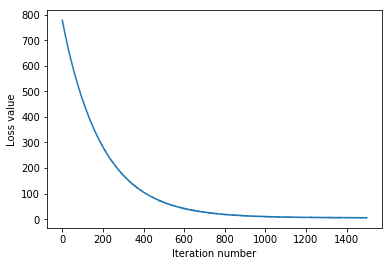

In [15]:
# Uma estratégia de depuração muito útil é plotar a perda em função 
# do número de iterações
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [16]:
# Implemente agora a função LinearSVM.predict e avalie o resultado de predição
# tanto no conjunto de treinamento quanto no conjunto de validação
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.383571
validation accuracy: 0.383000


In [17]:
# Utilize o conjunto de validação para ajustar os hiperparâmetros (taxa de 
# aprendizado e regularização). Você deve experimentar diferentes intervalos
# para ambos. Se você proceder corretamente deve ser capaz de obter uma acurácia
# em torno de 0.4 no conjunto de validação.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results é um dicionário que mapeia tuplas da seguinte forma
# (learning_rate, regularization_strength) em tuplas cuja forma é 
# (training_accuracy, validation_accuracy). A acurácia é obtida simplesmente como
# a fração dos pontos corretamente classificados (ou taxa de acerto).
results = {}
best_val = -1   # O valor da maior acurácia de validação obtida até o momento.
best_svm = None # O objeto LinearSVM que alcançou o melhor resultado.

################################################################################
# TODO:                                                                        #
# Escrever o código que escolhe os melhores hiperparâmetros usando o conjunto  #
# de validação. Para cada combinação de hiperparâmetros, treina-se um SVM      #
# linear sobre o conjunto de treinamento, calcula-se sua acurácia sobre os     #
# conjuntos de de treinamento e validação e armazena-se esses valores no       #
# dicionario results. Além disso, armazena-se a melhor acurácia de validação   #
# em best_val e o objeto LinearSVM que obteve esse resultado em best_svm.      #
#                                                                              #
# Dica: Você deve usar um valor pequeno para num_iters na medida que você      #
# verifica seu código, assim o SVM não leva muito tempo treinamento. Quando    #
# você estiver confiante de que seu código funciona corretamente, então você   #
# pode re-executar utilizando o valor maior para num_iters.
################################################################################

n_iters = 1000

svm = LinearSVM()
best_train = 0
best_lr = 0
best_reg = 0

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=n_iters, verbose=False)
        
        #predict
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        
        #validate
        cur_train = np.mean(y_train == y_train_pred)
        cur_valid = np.mean(y_val == y_val_pred)
        
        #save results
        results[(lr, reg)] = (cur_train, cur_valid)
        
        #print
        print('lr: %e reg: %e train: %f valid: %f' % (lr, reg, cur_train, cur_valid))
        
        if cur_valid > best_val:
            best_val = cur_valid
            best_train = cur_train
            best_lr = lr
            best_reg = reg
            best_svm = svm #salva svm para uso posterior


################################################################################
#                              FIM DE SEU CÓDIGO                               #
################################################################################
    
# Exibe os resultados.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr: 1.000000e-07 reg: 2.500000e+04 train: 0.375551 valid: 0.371000
lr: 1.000000e-07 reg: 5.000000e+04 train: 0.371551 valid: 0.381000
lr: 5.000000e-05 reg: 2.500000e+04 train: 0.157449 valid: 0.137000


/home/falreis/Me/ppginf-disciplinas/deep_learning/tp1/code/dl/classifiers/linear_svm.py:84: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W) # W*W causa overflow
/home/falreis/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/falreis/Me/ppginf-disciplinas/deep_learning/tp1/code/dl/classifiers/linear_svm.py:84: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W) # W*W causa overflow


lr: 5.000000e-05 reg: 5.000000e+04 train: 0.140000 valid: 0.124000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.375551 val accuracy: 0.371000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.371551 val accuracy: 0.381000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.157449 val accuracy: 0.137000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.140000 val accuracy: 0.124000
best validation accuracy achieved during cross-validation: 0.381000


In [18]:
# Visualiza os resultados da validação cruzada
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# Plota acurácia do treinamento
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# Plota acurácia da valisação
colors = [results[x][1] for x in results] # tamanho default de marcadores é 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout()
plt.show()

In [19]:
# Avalia o melhor modelo SVM no conjunto de teste
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.143000


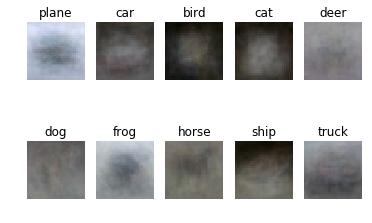

In [20]:
# Visualiza os pesos obtidos para cada classe.
# Dependendo de sua escolha de taxa de aprendizado e regularização, essas imagens
# podem ou não ser interessante de examinar.
w = best_svm.W[:-1,:] # remove o viés/bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Redimensiona os pesos para o intervalo entre 0 e 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Pergunta 02:
Descreva como as imagens de visualização dos pesos do SVM se parecem, e forneça uma explicação breve sobre a razão para elas se apresentarem de tal forma.

**Sua Resposta:** 

*As imagens dos pesos do SVM aparecem borradas. Como o SVM é um tipo de rede neural simples, ele não conseguiu absorver as informações necessárias para classificação correta das classes.*